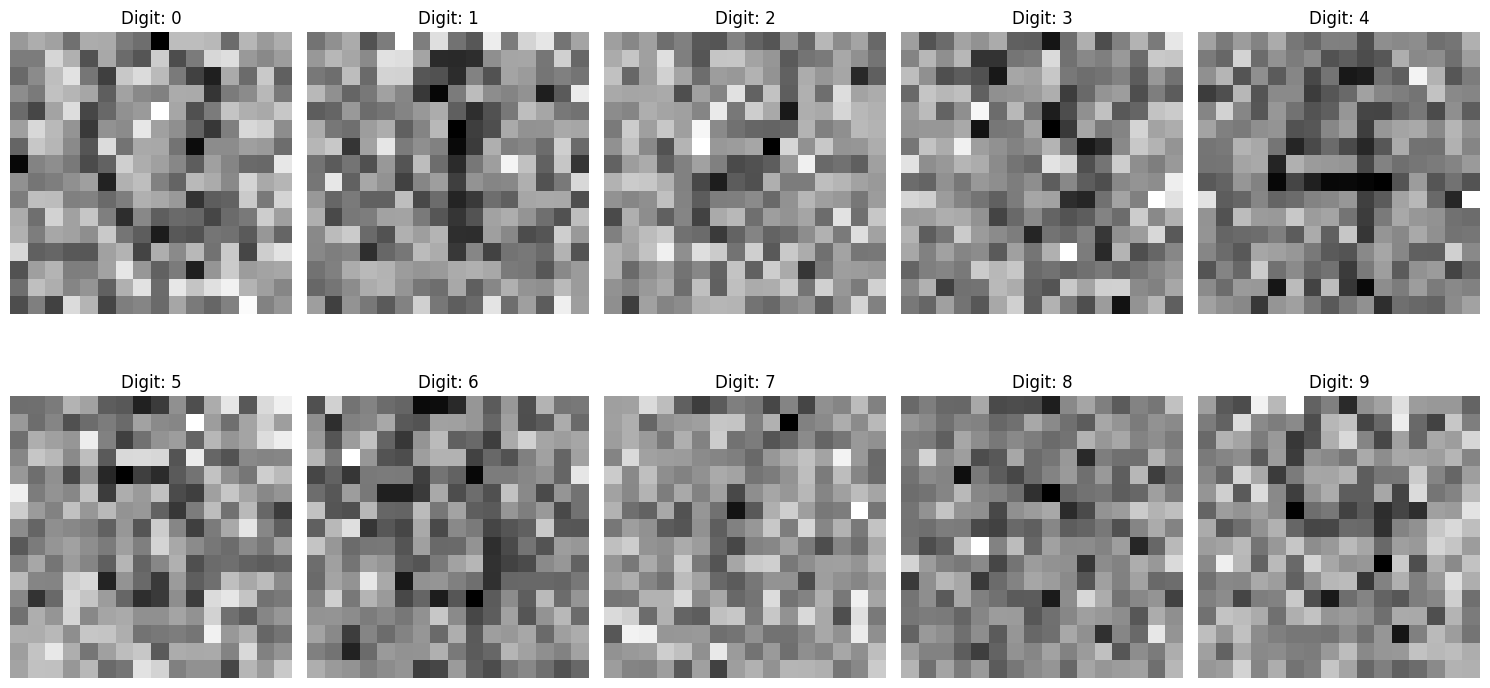

Number of extracted composite images: 10
Extracted digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
import zipfile
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Specify the path to your test_digits folder and the zip file
test_digits_folder = 'test_digits'
zip_filename = 'experiment_results_participant65.zip'
zip_filepath = os.path.join(test_digits_folder, zip_filename)

# Create a dictionary to store the extracted images
extracted_images = {}

# Open the zip file
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    # List all files in the zip
    file_list = zip_ref.namelist()
    
    # Filter for composite images
    composite_images = [f for f in file_list if f.endswith('_composite_participant65.png')]
    
    # Extract and store the composite images
    for image_name in composite_images:
        with zip_ref.open(image_name) as file:
            img = Image.open(file)
            img_array = np.array(img)
            
            # Extract digit (ground truth) from filename
            digit = int(image_name.split('_')[0])
            
            extracted_images[digit] = img_array

# Display the extracted images
plt.figure(figsize=(15, 8))
for i, (digit, img_array) in enumerate(sorted(extracted_images.items())):
    plt.subplot(2, 5, i+1)
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Digit: {digit}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of extracted composite images: {len(extracted_images)}")
print("Extracted digits:", sorted(extracted_images.keys()))

# You can now use the extracted_images dictionary for further analysis
# For example, to access the image array for digit 5:
# digit_5_array = extracted_images[5]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
import zipfile
import os

# Load the pre-trained model
model = load_model('mnist_noisy_16x16_classifier.h5')

# Function to preprocess image for the model
def preprocess_image(img_array):
    print(f"Original image shape: {img_array.shape}")
    print(f"Image data type: {img_array.dtype}")
    
    # Ensure the image is 2D (grayscale)
    if len(img_array.shape) == 3:
        img_array = np.mean(img_array, axis=-1)
    
    # Ensure the image is 16x16
    if img_array.shape != (16, 16):
        raise ValueError(f"Unexpected image shape: {img_array.shape}")
    
    # Reshape and normalize
    img_array = img_array.reshape(1, 16, 16, 1)
    img_array = img_array.astype('float32') / 255.0
    return img_array

# Path to the zip file
zip_filepath = 'test_digits/experiment_results_participant65.zip'

# Dictionary to store results
results = {}

# Open the zip file and process images
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    for filename in zip_ref.namelist():
        if filename.endswith('_composite_participant65.png'):
            true_label = int(filename.split('_')[0])
            with zip_ref.open(filename) as file:
                img = Image.open(file)
                img_array = np.array(img)
                
                print(f"\nProcessing image: {filename}")
                try:
                    processed_img = preprocess_image(img_array)
                    
                    # Get model prediction
                    prediction = model.predict(processed_img)[0]
                    predicted_label = np.argmax(prediction)
                    confidence = prediction[predicted_label]
                    
                    results[true_label] = {
                        'predicted_label': predicted_label,
                        'confidence': confidence,
                        'image': img_array
                    }
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue

# Display results
plt.figure(figsize=(20, 10))
for i, (true_label, data) in enumerate(sorted(results.items())):
    plt.subplot(2, 5, i+1)
    plt.imshow(data['image'], cmap='gray')
    plt.title(f"True: {true_label}, Pred: {data['predicted_label']}\nConf: {data['confidence']:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print detailed results
print("\nDetailed Results:")
print("True Label | Predicted Label | Confidence")
print("-" * 45)
for true_label, data in sorted(results.items()):
    print(f"{true_label:^10} | {data['predicted_label']:^15} | {data['confidence']:^10.2f}")

# Calculate accuracy
accuracy = sum(1 for true_label, data in results.items() if true_label == data['predicted_label']) / len(results)
print(f"\nOverall Accuracy: {accuracy:.2f}")

# Calculate average confidence
avg_confidence = sum(data['confidence'] for data in results.values()) / len(results)
print(f"Average Confidence: {avg_confidence:.2f}")

ValueError: object __array__ method not producing an array

Now, let's address the issue of improving the model's robustness. The current results show low accuracy and a bias towards predicting '2', which indicates that the model needs significant improvement. Here are several strategies we can employ to make the model more robust:

Data Augmentation:
Increase the variety of training data by applying random transformations.

Noise Injection:
Add various types of noise to the training images to make the model more resilient to noisy inputs.

Ensemble Methods:
Train multiple models and combine their predictions.

Regularization:
Apply techniques like dropout or L2 regularization to prevent overfitting.

Architecture Modification:
Experiment with different network architectures.

Transfer Learning:
Use a pre-trained model on a larger dataset and fine-tune it for your specific task.

Balanced Dataset:
Ensure your training data has a balanced representation of all classes.

In [5]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the three models
models = [load_model(f'mnist_noisy_16x16_model_{i+1}.h5') for i in range(3)]

def ensemble_predict(image):
    # Ensure image is in the correct shape (1, 16, 16, 1)
    if image.shape != (1, 16, 16, 1):
        image = image.reshape(1, 16, 16, 1)
    predictions = [model.predict(image) for model in models]
    return np.mean(predictions, axis=0)

# In your main loop, replace the prediction step with:
prediction = ensemble_predict(processed_img)[0]
predicted_label = np.argmax(prediction)
confidence = prediction[predicted_label]

ValueError: object __array__ method not producing an array

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
import zipfile
import os

# Load the three pre-trained models
models = [load_model(f'mnist_noisy_16x16_model_{i+1}.h5') for i in range(3)]

# Function to preprocess image for the model
def preprocess_image(img_array):
    print(f"Original image shape: {img_array.shape}")
    print(f"Image data type: {img_array.dtype}")
    
    # Ensure the image is 2D (grayscale)
    if len(img_array.shape) == 3:
        img_array = np.mean(img_array, axis=-1)
    
    # Ensure the image is 16x16
    if img_array.shape != (16, 16):
        raise ValueError(f"Unexpected image shape: {img_array.shape}")
    
    # Reshape and normalize
    img_array = img_array.reshape(1, 16, 16, 1)
    img_array = img_array.astype('float32') / 255.0
    return img_array

# Function to get ensemble predictions
def ensemble_predict(image):
    predictions = [model.predict(image) for model in models]
    return np.mean(predictions, axis=0)

# Path to the zip file
zip_filepath = 'test_digits/experiment_results_participant65.zip'

# Dictionary to store results for each model and ensemble
results = {i: {} for i in range(4)}  # 0, 1, 2 for individual models, 3 for ensemble

# Open the zip file and process images
with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
    for filename in zip_ref.namelist():
        if filename.endswith('_composite_participant65.png'):
            true_label = int(filename.split('_')[0])
            with zip_ref.open(filename) as file:
                img = Image.open(file)
                img_array = np.array(img)
                
                print(f"\nProcessing image: {filename}")
                try:
                    processed_img = preprocess_image(img_array)
                    
                    # Get predictions for each model and ensemble
                    for i in range(3):
                        prediction = models[i].predict(processed_img)[0]
                        predicted_label = np.argmax(prediction)
                        confidence = prediction[predicted_label]
                        results[i][true_label] = {
                            'predicted_label': predicted_label,
                            'confidence': confidence,
                            'image': img_array
                        }
                    
                    # Ensemble prediction
                    ensemble_prediction = ensemble_predict(processed_img)[0]
                    ensemble_label = np.argmax(ensemble_prediction)
                    ensemble_confidence = ensemble_prediction[ensemble_label]
                    results[3][true_label] = {
                        'predicted_label': ensemble_label,
                        'confidence': ensemble_confidence,
                        'image': img_array
                    }
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue

# Function to display and print results
def display_results(model_results, model_name):
    plt.figure(figsize=(20, 10))
    for i, (true_label, data) in enumerate(sorted(model_results.items())):
        plt.subplot(2, 5, i+1)
        plt.imshow(data['image'], cmap='gray')
        plt.title(f"True: {true_label}, Pred: {data['predicted_label']}\nConf: {data['confidence']:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Results for {model_name}", fontsize=16)
    plt.show()

    print(f"\nDetailed Results for {model_name}:")
    print("True Label | Predicted Label | Confidence")
    print("-" * 45)
    for true_label, data in sorted(model_results.items()):
        print(f"{true_label:^10} | {data['predicted_label']:^15} | {data['confidence']:^10.2f}")

    accuracy = sum(1 for true_label, data in model_results.items() if true_label == data['predicted_label']) / len(model_results)
    avg_confidence = sum(data['confidence'] for data in model_results.values()) / len(model_results)
    print(f"\nOverall Accuracy: {accuracy:.2f}")
    print(f"Average Confidence: {avg_confidence:.2f}")

# Display and print results for each model and ensemble
for i in range(4):
    model_name = f"Model {i+1}" if i < 3 else "Ensemble"
    display_results(results[i], model_name)

ValueError: object __array__ method not producing an array

ooof now we always predict 1

I apologize for the disappointing results. This outcome suggests that our models are severely underfitting or have converged to a suboptimal solution. Let's analyze the situation and consider some improvements:

Model Complexity: Our current model might be too simple for the task, especially given the noisy and small (16x16) images.

Training Data: The resizing of MNIST to 16x16 might have lost too much information.

Regularization: We might be over-regularizing, causing the model to underfit.

Learning Rate: The learning rate might be too high, causing the model to overshoot the optimal solution.

Training Duration: We might not be training for long enough.